This notebook is based on:
- [Introduction to image segmentation - EPFL Center for Imaging](https://imaging.epfl.ch/field-guide/sections/image_segmentation/notebooks/segmentation_intro.html)
- [Thresholding example - scikit-image](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py)

# ✂️ Introduction to image segmentation

This tutorial will give you a practical introduction to image segmentation. We'll aim to produce a segmentation mask that identifies objects of interest in an image. We will attempt to separate the objects from the background. Then, we'll see how to distinguish individual objects.


## Setup

First, make sure that you are executing this notebook in an environment with all the necessary packages installed. We'll import every function and library that we need in the cell below. We'll use these imports progressively in the notebook.

In [12]:
import ipywidgets
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage.data
from skimage.io import imshow
from skimage.exposure import histogram
from skimage.filters import sobel, threshold_otsu
from skimage.measure import regionprops_table
from skimage.segmentation import watershed
from skimage.color import label2rgb

## Load an image

We will use the `coins` image from `skimage.data` as an example. This image shows several coins outlined against a darker background.

In [13]:
image = skimage.data.coins()

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape: (303, 384) and data type uint8
Intensity range: [1 - 252]


This is what our image looks like:

/tmp/ipykernel_30115/3355601266.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(image)


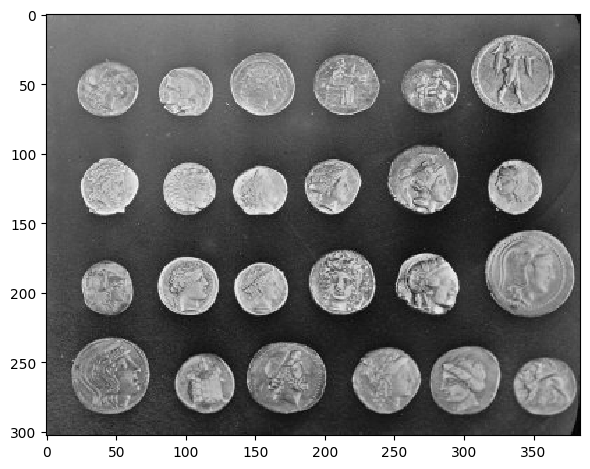

In [14]:
imshow(image)

We can also plot the image histogram:

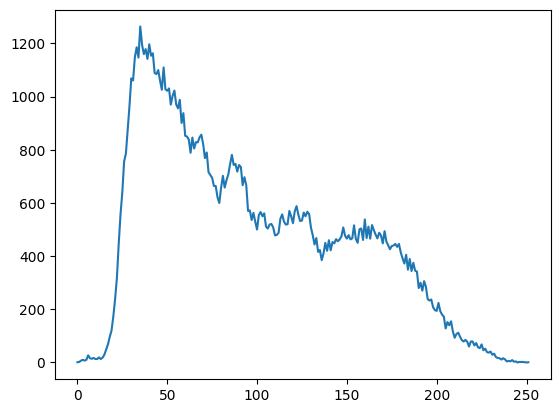

In [15]:
hist, hist_centers = histogram(image)

plt.plot(hist)
plt.show()

## Thresholding

First, we are going to attempt to segment the image by thresholding the graylevel intensities. For this, we select a threshold, and then apply it to the image. All the pixel intensity values above the selected threshold become 1, and the rest 0. This type of image array is known as a **binary mask**.

To create a suitable binary mask, the challenge is to find a threshold value that works well for our image (if that is possible), that is, which accurately separates the foreground from the background pixels.

In the cell below, we show you a way of creating an interactive threshold function using `ipywidgets`. Move the slider to see the effect on the segmentation mask.

In [23]:
def segment_image(threshold):
    binary_image = image > threshold
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(binary_image, cmap='gray')
    ax[1].set_title('Segmented Image')
    ax[1].axis('off')
    plt.show()

threshold_slider = ipywidgets.IntSlider(
    value=threshold_otsu(image),
    min=0,
    max=255,
    step=1,
    description='Threshold:',
    continuous_update=True
)

ipywidgets.interactive(segment_image, threshold=threshold_slider)


interactive(children=(IntSlider(value=107, description='Threshold:', max=255), Output()), _dom_classes=('widge…

### Automatic thresholding
There are methods to automatically select intensity thresholds based on the image histogram. One of these methods is Otsu thresholding. You can try the following:


However, this only selects a good guess for a threshold.

Binary image with threshold 107


/tmp/ipykernel_30115/1499408416.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(binary_image)


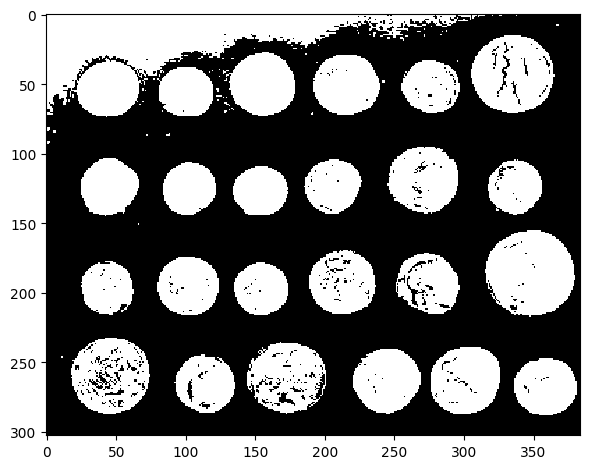

In [25]:
from skimage.filters import threshold_otsu
threshold = threshold_otsu(image)
binary_image = image > threshold
print(f'Binary image with threshold {threshold}')
imshow(binary_image)

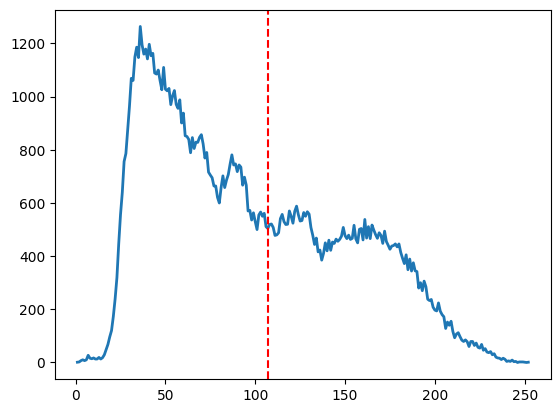

In [28]:
# Plot the histogram of the image with the threshold as a vertical line
plt.plot(hist_centers, hist, lw=2)
plt.axvline(threshold, color='r', ls='--')
plt.show()


There are other threshold-based algorithms that we can easily try out with the `try_all_threshold` function of `scikit-image`:

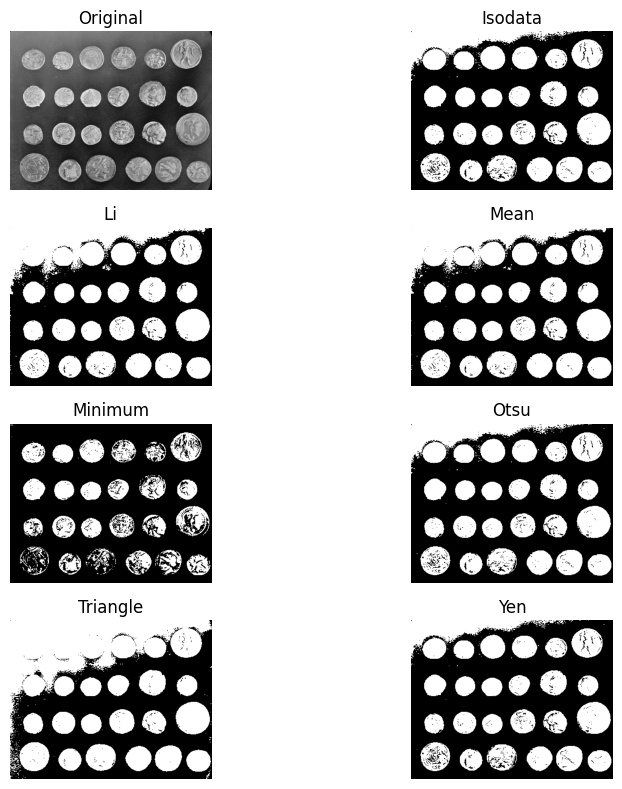

In [29]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()

It looks like simply thresholding the image leads either to missing significant parts of the coins, or to merging parts of the background with the coins. This is due to the inhomogeneous lighting of the image.

Therefore, we'll try a more advanced segmentation approach.

## Watershed segmentation

The watershed transform floods an image of elevation starting from markers, in order to determine the catchment basins of these markers. Watershed lines separate these catchment basins, and correspond to the desired segmentation.

The choice of the elevation map is critical for good segmentation. Here, we use the Sobel operator for computing the amplitude of the intensity gradient in the original image (the edges):

/tmp/ipykernel_30115/2680505110.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(edges)


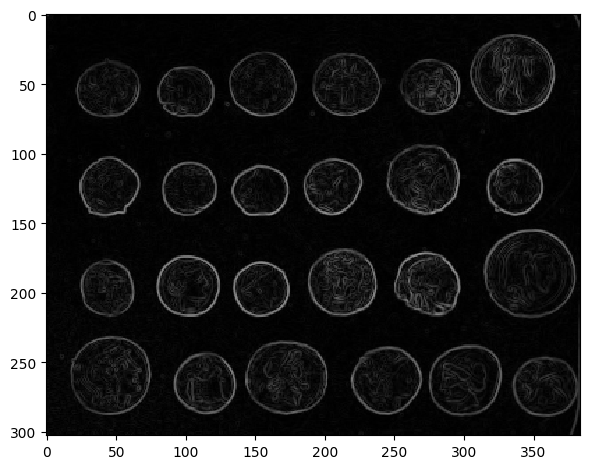

In [55]:
edges = sobel(image)

imshow(edges)


Let us first determine markers of the coins and the background. These markers are pixels that we can label unambiguously as either object or background. Here, the markers are found at the two extreme parts of the histogram of gray values:

/tmp/ipykernel_30115/3145287531.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(markers)
/home/daveni/w/phd/qbi/Quantitative-Big-Imaging-2025/.venv/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


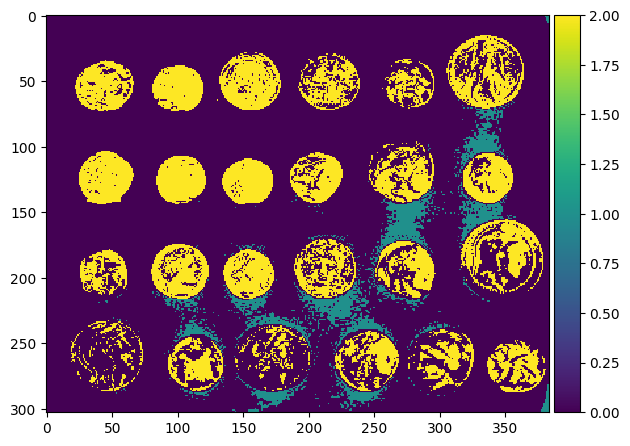

In [58]:
markers = np.zeros_like(image)
markers[image < 30] = 1
markers[image > 150] = 2
imshow(markers)

Let us now compute the watershed transform:

/tmp/ipykernel_30115/2481877770.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(segmentation)
/home/daveni/w/phd/qbi/Quantitative-Big-Imaging-2025/.venv/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


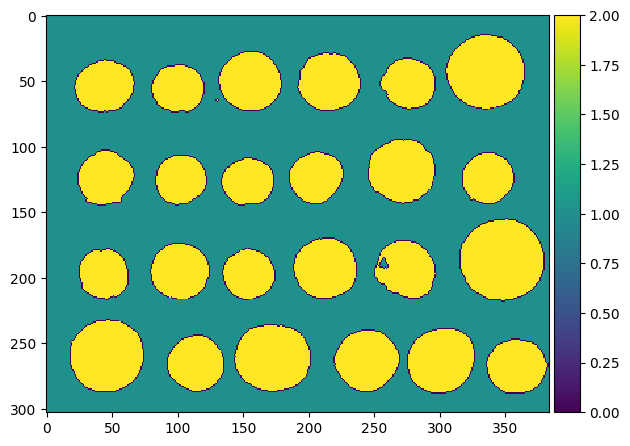

In [59]:
segmentation = watershed(edges, markers, watershed_line=True)

imshow(segmentation)

With this method, the result is satisfying for all coins. Even if the markers for the background were not well distributed, the barriers in the elevation map were high enough for these markers to flood the entire background.

To further improve the segmentation, we remove a few small holes using the `scipy.ndimage.binary_fill_holes()` function:

/tmp/ipykernel_30115/3759938999.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(segmentation)


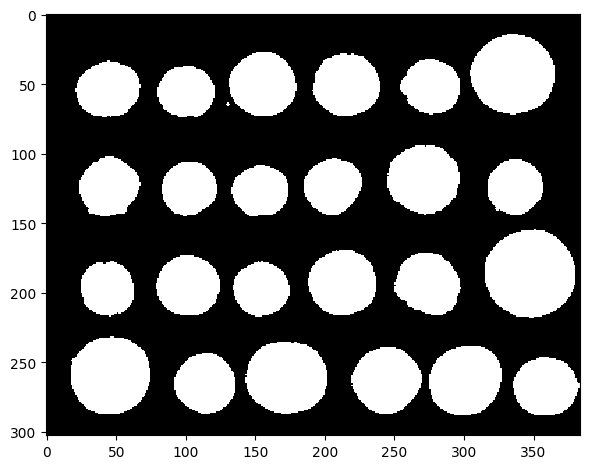

In [60]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

imshow(segmentation)

Our binary mask looks good. The next step is to distinguis the coins from each other, which we can do using an algorithm known as connected components labeling.

## Connected component labeling

Conceptionally, label images are an extension of binary masks. In a label image, all pixels with value 0 correspond to background. Pixels with a value larger than 0 denote that the pixel belongs to an object and identifies that object with the given number. A pixel with value `1` belongs to  first object and pixels with value `2` belongs to a second object and so on. When objects are labeled subsequently, the maximum value in a label mask corresponds to the number of objects in the image.

Let's label all the coins in our binary mask using the `ndi.label` function from Scipy:

/tmp/ipykernel_30115/3759763067.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(labeled_segmentation)
/home/daveni/w/phd/qbi/Quantitative-Big-Imaging-2025/.venv/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


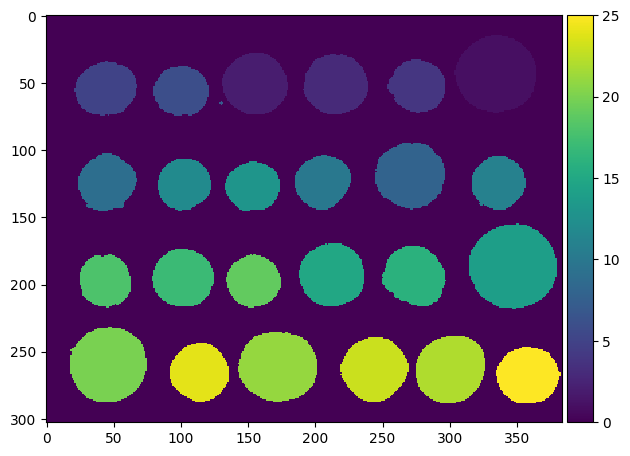

In [61]:
labeled_segmentation, _ = ndi.label(segmentation)

imshow(labeled_segmentation)

This is nice. Now, what if we want to measure some properties of our labeled objects, such as their size?

## Displaying a figure

We use the `label2rgb` function from Scikit-image to display the segmentation overlaid on the original image.

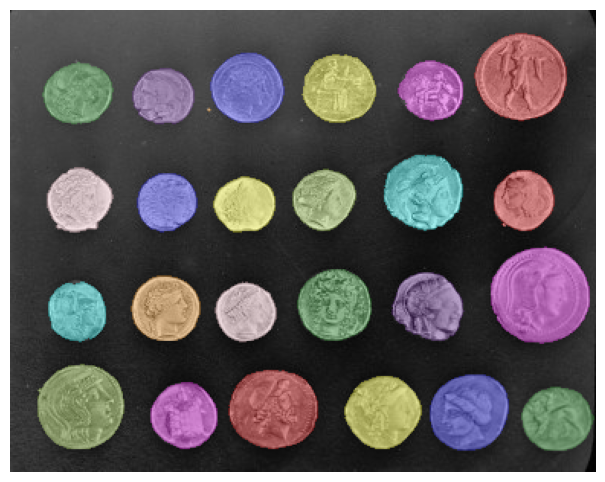

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
rgb_composite = label2rgb(labeled_segmentation, image=image, bg_label=0)
ax.imshow(rgb_composite)
plt.axis('off')
plt.show()